# Identity Graph for GraphRAG Demo

In this notebook, we will create a sample identity graph or customer 360 graph in [Amazon Neptune](https://aws.amazon.com/neptune/) for GraphRAG.

## 1. Background

An identity graph or customer 360 graph helps organizations solve use cases like identity resolution including targeted advertising, audience segmentation, and product recommendations. We will work with a canonical model for a sample identity graph that combines data across multiple silos (user profile data, user logs data and user transactions data) to provide a holistic view of a user/identity within a system.

Details can be found at [Neptune sample identity graph notebook](https://github.com/aws/graph-notebook/tree/main/src/graph_notebook/notebooks/01-Neptune-Database/03-Sample-Applications/03-Identity-Graphs), which also includes the setup of a data ingestion pipeline using AWS Glue to build such an identity graph. We will use a much simpler method to load the same data into Amazon Neptune for GraphRAG.

## 2. Initial Setup

You may run this notebook on [Neptune graph notebooks](https://docs.aws.amazon.com/neptune/latest/userguide/graph-notebooks.html) for easier setup.

### Install Sample Data

We use pre-defined mock data. Run below commands to download the files.

In [2]:
%%bash

pip install pandas
mkdir {source,source/demographics,source/telemetry,source/transactions}

curl https://d2bzopfonul8zc.cloudfront.net/source/demographics/demographics.csv --output source/demographics/demographics.csv
curl https://d2bzopfonul8zc.cloudfront.net/source/telemetry/telemetry.csv --output source/telemetry/telemetry.csv
curl https://d2bzopfonul8zc.cloudfront.net/source/transactions/transactions.csv --output source/transactions/transactions.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162k  100  162k    0     0  5977k      0 --:--:-- --:--:-- --:--:-- 6028k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2574k  100 2574k    0     0  84.4M      0 --:--:-- --:--:-- --:--:-- 86.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  532k  100  532k    0     0  19.7M      0 --:--:-- --:--:-- --:--:-- 20.0M


### Configure Custom Visualization Options

The `%%graph_notebook_vis_options` magic will allow us to define how different graph elements are displayed in the visualization created by the notebook. 

For example, we can create a configuration that will use a custom icon for "User" vertexes:

```
"User": {
  "shape": "icon",
  "icon": {
    "weight": "bold",
    "face": "'Font Awesome 5 Free'",
    "code": "\uf2bb",
    "color": "red"
  }
}
```

This will display each User vertex as:

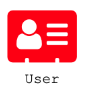

Now, run the next cell to set the custom vis settings for the examples that will follow.

In [3]:
%%graph_notebook_vis_options

{"groups":{"User":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"red"}},"UserAgent":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"green"}},"Page":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"orange"}},"Session":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"blue"}},"Email":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"blue"}},"Address":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"blue"}},"IPAddress":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"blue"}},"Phone":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"blue"}},"City":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"blue"}},"State":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"blue"}},"Product":{"shape":"icon","icon":{"weight":"bold","face":"'Font Awesome 5 Free'","code":"","color":"blue"}}},"edges":{"color":{"inherit":false},"smooth":{"enabled":true,"type":"straightCross"},"arrows":{"to":{"enabled":false,"type":"arrow"}},"font":{"face":"courier new"}},"interaction":{"hover":true,"hoverConnectedEdges":true,"selectConnectedEdges":false},"physics":{"minVelocity":0.75,"barnesHut":{"centralGravity":0.1,"gravitationalConstant":-50450,"springLength":95,"springConstant":0.04,"damping":0.09,"avoidOverlap":0.1},"solver":"barnesHut","enabled":true,"adaptiveTimestep":true,"stabilization":{"enabled":true,"iterations":1}}}

Visualization settings successfully changed to:

{
  "physics": {
    "barnesHut": {
      "centralGravity": 0.1,
      "gravitationalConstant": -50450,
      "avoidOverlap": 0.1,
      "damping": 0.09,
      "springConstant": 0.04,
      "springLength": 95
    },
    "enabled": true,
    "minVelocity": 0.75,
    "solver": "barnesHut",
    "stabilization": {
      "iterations": 1,
      "enabled": true
    },
    "adaptiveTimestep": true,
    "simulationDuration": 1500,
    "disablePhysicsAfterInitialSimulation": false
  },
  "interaction": {
    "hover": true,
    "selectConnectedEdges": false,
    "hoverConnectedEdges": true
  },
  "edges": {
    "font": {
      "face": "courier new"
    },
    "smooth": {
      "type": "straightCross",
      "enabled": true
    },
    "arrows": {
      "to": {
        "type": "arrow",
        "enabled": false
      }
    },
    "color": {
      "inherit": false
    }
  },
  "nodes": {
    "borderWidthSelected": 0,
    "borderWidth": 0,
    "color": 

## 3. Reviewing the Source Data

The sample data sources contains user profile, user logs and user transactions.

After running the previous setup steps, these data sets should now be available in the local notebooks directory. Let's verify this by reviewing the contents of each dataset via Pandas datatables.

### Demographics (User's Profile Data)

Each row in the sample demographics dataset, representing a single user, should have columns for each of the properties: id, name, phone, email, city, state, country, pincode, address, joineddate, updateddate.

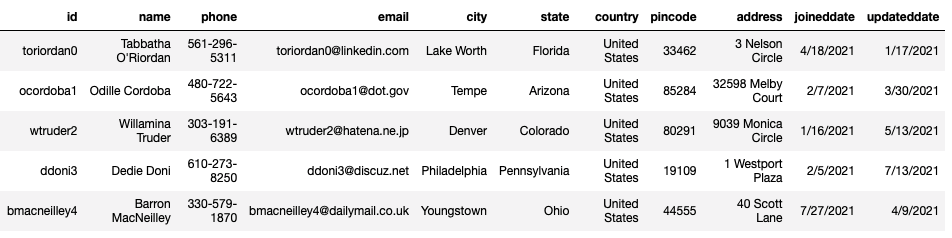

Verify that our Demographics data is correct by observing that the output of the following cell matches the table above.

In [4]:
import pandas as pd

df = pd.read_csv('./source/demographics/demographics.csv')
df.head()

,id,name,phone,email,city,state,country,pincode,address,joineddate,updateddate
0,toriordan0,Tabbatha O'Riordan,561-296--XXX,toriordan0@neptunedemos.com,Lake Worth,Florida,United States,33462,3 Nelson Circle,4/18/2021,1/17/2021
1,ocordoba1,Odille Cordoba,480-722--XXX,ocordoba1@neptunedemos.com,Tempe,Arizona,United States,85284,32598 Melby Court,2/7/2021,3/30/2021
2,wtruder2,Willamina Truder,303-191--XXX,wtruder2@neptunedemos.com,Denver,Colorado,United States,80291,9039 Monica Circle,1/16/2021,5/13/2021
3,ddoni3,Dedie Doni,610-273--XXX,ddoni3@neptunedemos.com,Philadelphia,Pennsylvania,United States,19109,1 Westport Plaza,2/5/2021,7/13/2021
4,bmacneilley4,Barron MacNeilley,330-579--XXX,bmacneilley4@neptunedemos.com,Youngstown,Ohio,United States,44555,40 Scott Lane,7/27/2021,4/9/2021


The Demographics ETL job will transform each row into **User**, **Phone**, **City**, **Email**, and **Country** nodes, and create relationships known as "edges" between them.

### Telemetry (User's Session Logs)

Each row in the sample telemetry dataset has information about entries in user's browsing history; these are: session_id, user_agent, ip_address, siteid, pageid, session_start. 

The telemetry dataset contain data for both authenticated and unauthenticated users. Unauthenticated records will not have an entry for user_id field.

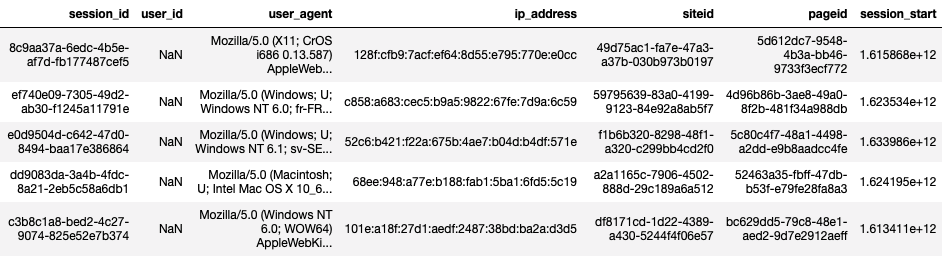

Verify that our Telemetry data is correct by observing that the output of the following cell matches the table above.

In [5]:
df = pd.read_csv('./source/telemetry/telemetry.csv')
df.head()

,session_id,user_id,user_agent,ip_address,siteid,pageid,session_start
0,8c9aa37a-6edc-4b5e-af7d-fb177487cef5,NaN,Mozilla/5.0 (X11; CrOS i686 0.13.587) AppleWeb...,128f:cfb9:7acf:ef64:8d55:e795:770e:e0cc,49d75ac1-fa7e-47a3-a37b-030b973b0197,5d612dc7-9548-4b3a-bb46-9733f3ecf772,1.615868e+12
1,ef740e09-7305-49d2-ab30-f1245a11791e,NaN,Mozilla/5.0 (Windows; U; Windows NT 6.0; fr-FR...,c858:a683:cec5:b9a5:9822:67fe:7d9a:6c59,59795639-83a0-4199-9123-84e92a8ab5f7,4d96b86b-3ae8-49a0-8f2b-481f34a988db,1.623534e+12
2,e0d9504d-c642-47d0-8494-baa17e386864,NaN,Mozilla/5.0 (Windows; U; Windows NT 6.1; sv-SE...,52c6:b421:f22a:675b:4ae7:b04d:b4df:571e,f1b6b320-8298-48f1-a320-c299bb4cd2f0,5c80c4f7-48a1-4498-a2dd-e9b8aadcc4fe,1.633986e+12
3,dd9083da-3a4b-4fdc-8a21-2eb5c58a6db1,NaN,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6...,68ee:948:a77e:b188:fab1:5ba1:6fd5:5c19,a2a1165c-7906-4502-888d-29c189a6a512,52463a35-fbff-47db-b53f-e79fe28fa8a3,1.624195e+12
4,c3b8c1a8-bed2-4c27-9074-825e52e7b374,NaN,Mozilla/5.0 (Windows NT 6.0; WOW64) AppleWebKi...,101e:a18f:27d1:aedf:2487:38bd:ba2a:d3d5,df8171cd-1d22-4389-a430-5244f4f06e57,bc629dd5-79c8-48e1-aed2-9d7e2912aeff,1.613411e+12


The Telemetry import will transform each row into **Session**, **UserAgent**, **IPAddress**, **Site** and **Page** nodes. The job will overlay this data on top of existing user profile data created by the Demographics job that precedes it. 

### Transactions (User's Purchase History)

Each row in the sample dataset represents an entry in a user's purchase history. The properties provided for each entry are: transaction_id, user_id, product_id, product_name, purchased_date, and review.

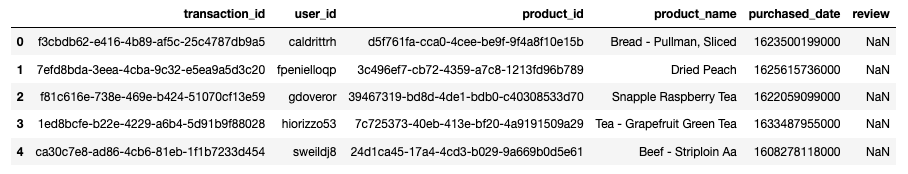
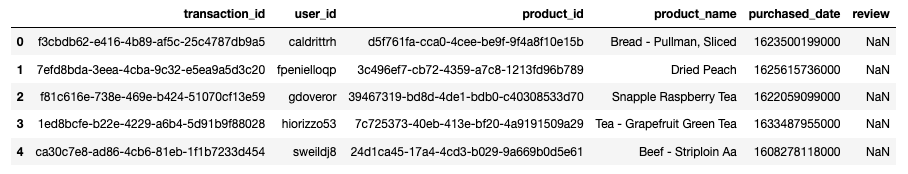

Verify that our Transactions data is correct by observing that the output of the following cell matches the table above.

In [6]:
df = pd.read_csv('./source/transactions/transactions.csv')
df.head()

,transaction_id,user_id,product_id,product_name,purchased_date,review
0,f3cbdb62-e416-4b89-af5c-25c4787db9a5,caldrittrh,d5f761fa-cca0-4cee-be9f-9f4a8f10e15b,"Bread - Pullman, Sliced",1623500199000,NaN
1,7efd8bda-3eea-4cba-9c32-e5ea9a5d3c20,fpenielloqp,3c496ef7-cb72-4359-a7c8-1213fd96b789,Dried Peach,1625615736000,NaN
2,f81c616e-738e-469e-b424-51070cf13e59,gdoveror,39467319-bd8d-4de1-bdb0-c40308533d70,Snapple Raspberry Tea,1622059099000,NaN
3,1ed8bcfe-b22e-4229-a6b4-5d91b9f88028,hiorizzo53,7c725373-40eb-413e-bf20-4a9191509a29,Tea - Grapefruit Green Tea,1633487955000,NaN
4,ca30c7e8-ad86-4cb6-81eb-1f1b7233d454,sweildj8,24d1ca45-17a4-4cd3-b029-9a669b0d5e61,Beef - Striploin Aa,1608278118000,NaN


The Transactions loading will create each Product node, and link it with User nodes already created by the Demographics loading.

## 4. Load all of the Data

With setup of the data ingestion pipeline complete, we are now ready to run the glue jobs for each of our datasets to create the final identity graph model in our Neptune database. Run each of the steps below in order.

We begin with configuring the endpoint information. Modify the <b>NEPTUNE_ENDPOINT</b> and <b>NEPTUNE_PORT</b> below then run the command.

In [ ]:
neptune_endpoint = 'NEPTUNE_ENDPOINT'
neptune_port = 'NEPTUNE_PORT'

### Load Demographics Data

The Demographics loading will load the initial consumer/user profile into Neptune. This will be the first step in constructing our identity graph. Once loaded, the graph should look something like:

<div>
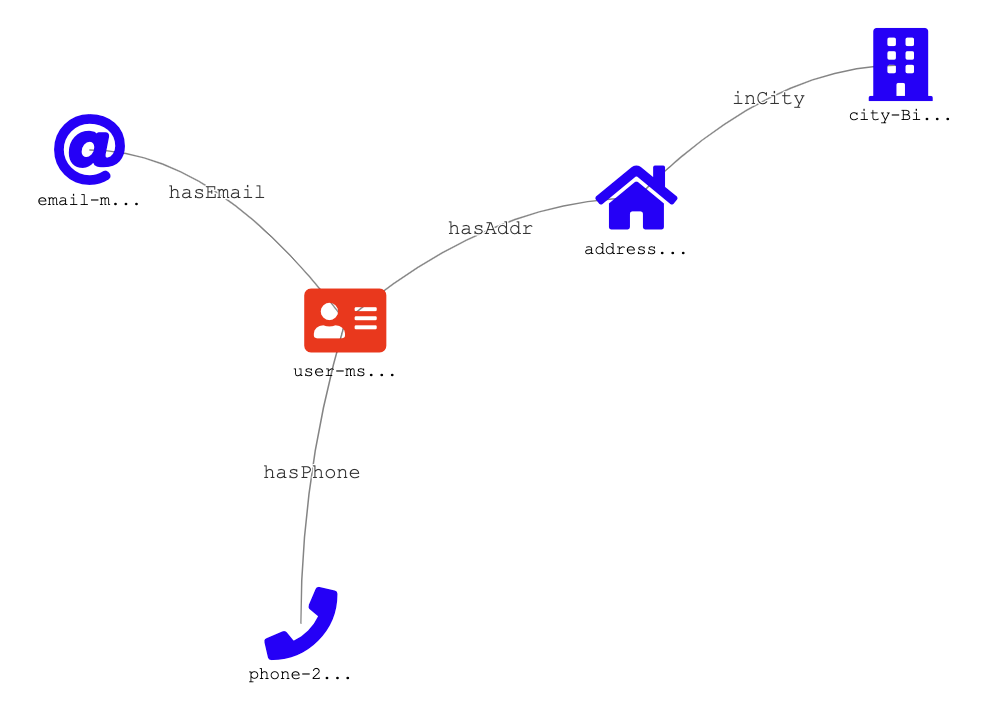
</div>

### Run the following cell to load the Demographics data into your Neptune database.

In [ ]:
import pandas as pd
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.process.traversal import T

# Create a connection to the Neptune database
connection = DriverRemoteConnection(f'wss://{neptune_endpoint}:{neptune_port}/gremlin', 'g')
g = traversal().withRemote(connection)

# Load the CSV data into a pandas DataFrame
df = pd.read_csv(f'source/demographics/demographics.csv')
total_transactions = len(df)

print("Loading from demographics.csv...")
transaction_counter = 0
# Create vertices and edges
for _, row in df.iterrows():
    transaction_counter += 1

    # Create user vertex
    user_vertex_id = f"user-{row['id']}"
    user_vertex = g.merge_v({(T.id): user_vertex_id, (T.label): 'User', 'name': row['name'], 'joineddate': row['joineddate'], 'updateddate': row['updateddate'], 'email': row['email']}).next()

    # Create phone vertex
    phone_vertex_id = f"phone-{row['phone']}"
    phone_vertex = g.merge_v({(T.id): phone_vertex_id, (T.label): 'Phone', 'phone': row['phone']}).next()
    g.V(user_vertex).addE('hasPhone').to(phone_vertex).property('id', 'hasPhone').next()

    # Create email vertex
    email_vertex_id = f"email-{row['email']}"
    email_vertex = g.merge_v({(T.id): email_vertex_id, (T.label): 'Email', 'email': row['email']}).next()
    g.V(user_vertex).addE('hasEmail').to(email_vertex).property('id', 'hasEmail').next()

    # Create address vertex
    address_vertex_id = f"address-{row['address']}"
    address_vertex = g.merge_v({(T.id): address_vertex_id, (T.label): 'Address', 'address': row['address']}).next()
    g.V(user_vertex).addE('hasAddr').to(address_vertex).property('id', 'hasAddr').next()

    # Create city vertex
    city_vertex_id = f"city-{row['city']}"
    city_vertex = g.merge_v({(T.id): city_vertex_id, (T.label): 'City', 'city': row['city']}).next()
    g.V(address_vertex).addE('inCity').to(city_vertex).property('id', 'inCity').next()

    # Create state vertex
    state_vertex_id = f"state-{row['state']}"
    state_vertex = g.merge_v({(T.id): state_vertex_id, (T.label): 'State', 'state': row['state']}).next()
    g.V(city_vertex).addE('inState').to(state_vertex).property('id', 'inState').next()

    # Create country vertex
    country_vertex_id = f"country-{row['country']}"
    country_vertex = g.merge_v({(T.id): country_vertex_id, (T.label): 'Country', 'country': row['country']}).next()
    g.V(state_vertex).addE('inCountry').to(country_vertex).property('id', 'inCountry').next()

    progress = (transaction_counter / total_transactions) * 100
    if (transaction_counter % 100 == 0) or (transaction_counter == total_transactions):
        print(f"Added {int(progress)}% ({transaction_counter}/{total_transactions})")

print("Done")

### Then, run the following to return the inserted data. Verify that the visualization displayed in the "Graph" output tab matches the graph above.

In [ ]:
%%gremlin -p v,oute,inv,oute,inv,oute,inv -de label -d id

g.V("user-msplevinsu").repeat(optional(outE().inV()).simplePath()).times(2).path()

### Load Telemetry Data

We have now created the base version of our identity graph with the user demographics data. In the graph returned from the query above, we can see how users can share metadata, such as addresses. 

Let's also integrate user telemetry data into the graph. We are primarily focused on the **user_agent**, **ip_address** and **pageid** properties. Once loaded, the identity graph data should appear as below:

<div>
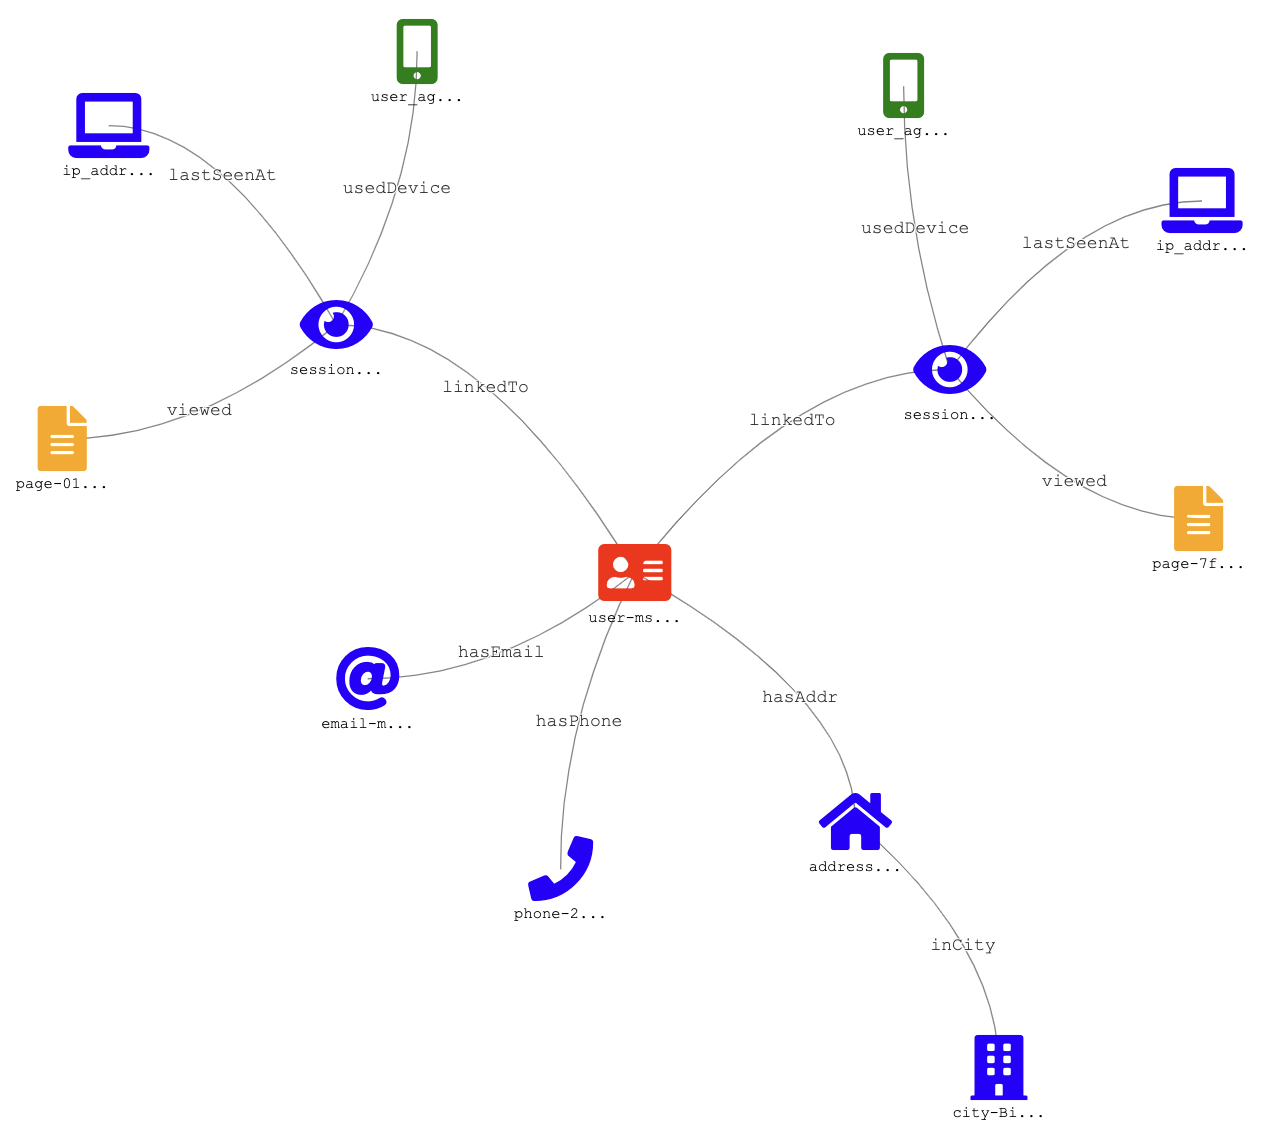
</div>

### Run the following cell to load the Telemetry data into your Neptune database.

In [ ]:
import pandas as pd
from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.process.traversal import T

# Create a connection to the Neptune database
connection = DriverRemoteConnection(f'wss://{neptune_endpoint}:{neptune_port}/gremlin', 'g')
g = traversal().withRemote(connection)

# Load the CSV data into a pandas DataFrame
df = pd.read_csv(f'source/telemetry/telemetry.csv')
total_transactions = len(df)

print("Loading from telemetry.csv...")
transaction_counter = 0
# Create vertices and edges
for _, row in df.iterrows():
    transaction_counter += 1

    # Create session vertex
    session_vertex_id = f"session_id-{row['session_id']}"
    session_vertex = g.merge_v({(T.id): session_vertex_id, (T.label): 'Session'}).next()

    # Create IP address vertex
    ip_vertex_id = f"ip_address-{row['ip_address']}"
    ip_vertex = g.merge_v({(T.id): ip_vertex_id, (T.label): 'IPAddress'}).next()
    g.V(session_vertex).addE('lastSeenAt').to(ip_vertex).property('id', 'lastSeenAt').next()

    # Create page vertex
    page_vertex_id = f"page-{row['pageid']}"
    page_vertex = g.merge_v({(T.id): page_vertex_id, (T.label): 'Page'}).next()
    g.V(session_vertex).addE('viewed').to(page_vertex).property('id', 'viewed').next()

    # Create user agent vertex
    user_agent_vertex_id = f"user_agent-{row['user_agent']}"
    user_agent_vertex = g.merge_v({(T.id): user_agent_vertex_id, (T.label): 'UserAgent'}).next()
    g.V(session_vertex).addE('usedDevice').to(user_agent_vertex).property('id', 'usedDevice').next()

    # Create user vertex and link to session (if user_id is not empty)
    if not pd.isna(row['user_id']):
        user_vertex_id = f"user-{row['user_id']}"
        user_vertex = g.merge_v({(T.id): user_vertex_id, (T.label): 'User'}).next()
        g.V(user_vertex).addE('linkedTo').to(session_vertex).property('id', 'linkedTo').property('session_start', row['session_start']).next()

    progress = (transaction_counter / total_transactions) * 100
    if (transaction_counter % 400 == 0) or (transaction_counter == total_transactions):
        print(f"Added {int(progress)}% ({transaction_counter}/{total_transactions})")

print("Done")

### Then, run the following to return the new graph. Verify that the visualization displayed in the "Graph" output tab matches the graph above.

In [ ]:
%%gremlin -p v,e,v,e,v -de label -d id

g.V("user-msplevinsu")
.repeat(optional(bothE().otherV()).simplePath())
.times(2)
.emit()
.path()
.by()

We also want to verify that no **session_id** vertex is linked to a **user_id** vertex.

In [ ]:
%%gremlin -p v,e,v -de label -d id

g.V("session_id-8c9aa37a-6edc-4b5e-af7d-fb177487cef5").bothE().otherV().path()

### Load Transactions Data

We currently have a graph where the user telemetry data has been integrated with the existing demographics info. In the result of the query above, you can see each user's session and its details. 

The final step will be to integrate the user transactions data into the graph. This dataset primarily focuses on products purchased by a user. The overlay of the transactions data onto the identity graph will expand it to look something like this: 

<div>
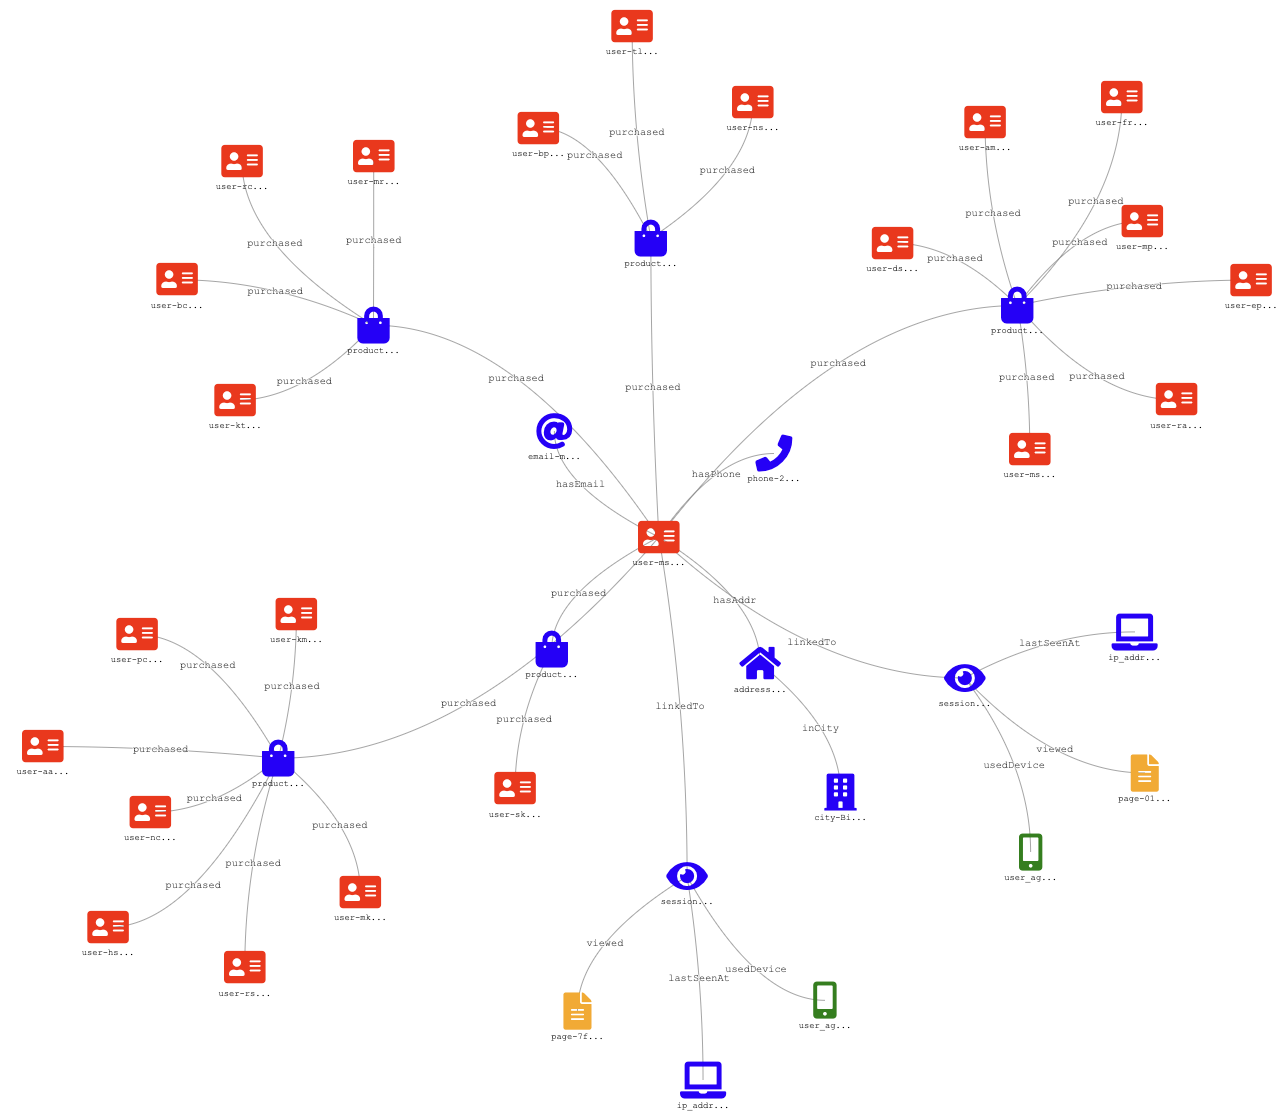
</div>

### Run the following cell to load the Transactions data into your Neptune database.

In [ ]:
import csv
import pandas as pd
from datetime import datetime
from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.process.traversal import T

# Create a connection to the Neptune database
connection = DriverRemoteConnection(f'wss://{neptune_endpoint}:{neptune_port}/gremlin', 'g')
g = traversal().withRemote(connection)

# Load the CSV data into a pandas DataFrame
df = pd.read_csv(f'source/transactions/transactions.csv')
total_transactions = len(df)

print("Loading from transactions.csv...")
transaction_counter = 0
# Create vertices and edges
for _, row in df.iterrows():
    transaction_counter += 1

    # Create product vertex
    product_vertex_id = f"product-{row['product_id']}"
    product_vertex = g.merge_v({(T.id): product_vertex_id, (T.label): 'Product', 'name': row['product_name']}).next()

    # Create user vertex
    user_vertex_id = f"user-{row['user_id']}"
    user_vertex = g.V().hasId(user_vertex_id).next()
    if not user_vertex:
        print(f"User vertex with ID {user_vertex_id} does not exist. Skipping this transaction.")
        continue

    # Create purchased edge
    purchased_date = datetime.fromtimestamp(int(row['purchased_date']) / 1000)
    g.V(user_vertex).addE('purchased').to(product_vertex).property('id', 'purchased').property('purchased_date', purchased_date).next()

    # Create review vertex (if review is not empty or NaN)
    # if not pd.isna(row['review']) and row['review']:
    #     review_vertex_id = f"review-{row['transaction_id']}"
    #     review_vertex = g.merge_v({(T.id): review_vertex_id, (T.label): 'Review', 'text': row['review']}).next()
    #     g.V(user_vertex).addE('wrote').to(review_vertex).property('id', 'wrote').next()
    #     g.V(review_vertex).addE('forProduct').to(product_vertex).property('id', 'forProduct').next()

    progress = (transaction_counter / total_transactions) * 100
    if (transaction_counter % 200 == 0) or (transaction_counter == total_transactions):
        print(f"Added {int(progress)}% ({transaction_counter}/{total_transactions})")

print("Done")

### Then, run the following to return the final combined identity graph.

In [ ]:
%%gremlin -p v,e,v,e,v,e,v -de label -d id

g.V("user-msplevinsu")
.repeat(optional(bothE().otherV()).simplePath())
.times(2)
.emit()
.path()
.by()

## 5. Let's get the identity subgraph for user *Armand Aglione*

In [7]:
%%gremlin -p v,e,v,e,v,e,v -de label -d id

g.V().has("name","Armand Aglione")
.repeat(optional(bothE().otherV()).simplePath())
.times(2)
.emit()
.path()
.by()

## Next Step

Congratulation, the identity graph is ready for use. All the data is loaded to the graph database. You can continue the GrapRAG by opening [02-GraphRAG.ipynb](./02-GraphRAG.ipynb).